<a href="https://colab.research.google.com/github/s20488/PJN/blob/main/Anastasiia_Ponkratova_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalowanie bibliotek

In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 11.7 MB/s eta 0:00:00


In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00


In [ ]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=459bf54d402748fd8cc192d5961e032717a48f78a2685e2c1c107e6183ebfe16
  Stored in directory: /root/.cache

## Import

In [ ]:
import torch
import pandas as pd
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Tuple
import pandas as pd
import random

## Dataset

In [ ]:
!wget https://gist.githubusercontent.com/AleksanderObuchowski/3c0bfe43fdef4bb198cddcd6d16cb668/raw/937abdfd933aaa86bc615ac6f72370ada40d4890/data.csv

--2024-10-25 23:00:16--  https://gist.githubusercontent.com/AleksanderObuchowski/3c0bfe43fdef4bb198cddcd6d16cb668/raw/937abdfd933aaa86bc615ac6f72370ada40d4890/data.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500336 (489K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 488.61K  --.-KB/s    in 0.1s    

2024-10-25 23:00:17 (3.32 MB/s) - ‘data.csv’ saved [500336/500336]



In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
df

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


## Embeddingi

Do stworzenia sieci wykorzystamy wcześniej już wytrenowane wektory słów z bilioteki Flair

In [ ]:
from flair.embeddings import FlairEmbeddings

# init embedding
embedder = FlairEmbeddings('news-forward')

2024-10-25 23:00:31,386 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmprz1_jxlp


100%|██████████| 69.7M/69.7M [00:06<00:00, 10.7MB/s]

2024-10-25 23:00:38,948 copying /tmp/tmprz1_jxlp to cache at /root/.flair/embeddings/news-forward-0.4.1.pt
2024-10-25 23:00:39,043 removing temp file /tmp/tmprz1_jxlp


In [ ]:
from flair.data import Sentence

sentence = Sentence('The grass is green .')

# embed words in sentence
embedder.embed(sentence)

[Sentence[5]: "The grass is green ."]

In [ ]:
sentence.tokens

[Token[0]: "The",
 Token[1]: "grass",
 Token[2]: "is",
 Token[3]: "green",
 Token[4]: "."]

In [ ]:
import numpy as np

np.array([token.embedding.cpu() for token in sentence.tokens])

array([[-0.00209332,  0.00050415,  0.04694446, ..., -0.00044014,
        -0.03930107,  0.01060069],
       [-0.00059658,  0.00467458,  0.02481948, ..., -0.00037749,
        -0.02356307,  0.01169971],
       [ 0.00109746, -0.00319513,  0.01561431, ..., -0.00612944,
         0.01119624,  0.00999922],
       [-0.00343969,  0.00026306,  0.02560665, ..., -0.0026115 ,
        -0.01177604,  0.04548658],
       [ 0.00082314,  0.00023236,  0.12620853, ..., -0.00023405,
         0.00386883,  0.00577251]], dtype=float32)

## Dataset

In [ ]:
class SpamDataset(Dataset):
    def __init__(self, data: pd.DataFrame, embedder, limit=200):

        self.labels = list(data["type"])[:limit] #limit do testów
        texts = list(data["text"])[:limit]

        self.embeddings = []
        for text in texts:
            sentence = Sentence(text)
            embedder.embed(sentence)
            embeddings = np.array([token.embedding.cpu().numpy() for token in sentence.tokens])
            self.embeddings.append(embeddings) #TODO: tablicy stworzenie embeddingów

        self.label_to_idx = {label: idx for idx, label in enumerate(set(self.labels))}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.labels) # TODO

    def __getitem__(self, idx):
        embeddings = self.embeddings[idx]
        label = self.labels[idx] # TODO: wczytanie pojedyńczego przykładu - wektorów słów i labela

        return {
            'text': torch.tensor(embeddings),
            'label': torch.tensor(label, dtype=torch.float)
        }

### Testy

In [ ]:
dataset = SpamDataset(df, embedder)

Shape powinien mieć kształt (ilość tokenów, rozmiar wektora słów)

In [ ]:
dataset[0]["text"].shape

torch.Size([24, 2048])

## Collate function

Aby móc połączyć dane w jednen bach muszą one miec takie same wymiary.
Ale zdania mogą być różnej długości czyli mieć różną ilość tokenów.

Dlatego musimy stworzyć funkcję która robi padding - sprowadza wszystkie zdania
w jednym batchu do tej samej długości.

https://codingnomads.com/pytorch-dataset-to-dataloader-using-collate-fn
https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

In [ ]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad sequences within the batch
    padded_texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)

    return {'text': padded_texts, 'label': torch.stack(labels)}

In [ ]:
class SpamDataModule(pl.LightningDataModule):
    def __init__(self, data_path: str, embedder, batch_size: int = 64, train_split: float = 0.75, max_length=100, limit = None):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.train_split = train_split
        self.embedder = embedder
        self.max_length = max_length
        self.limit = limit

    def prepare_data(self):
        self.data = pd.read_csv(self.data_path)

    def setup(self, stage: Optional[str] = None):
        train_size = int(len(self.data) * self.train_split)
        train_data = self.data.iloc[:train_size]
        val_data = self.data.iloc[train_size:]

        print(f"Train size: {len(train_data)}")
        print(f"Val size: {len(val_data)}")

        if stage == 'fit' or stage is None:
            self.train_dataset = SpamDataset(train_data, self.embedder, limit= self.limit)
            self.val_dataset = SpamDataset(val_data, self.embedder, limit = self.limit)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            collate_fn=collate_fn
        )

### Test

In [ ]:
dm = SpamDataModule("data.csv", embedder, limit =10)

In [ ]:
dm.prepare_data()
dm.setup(stage='fit')

# Get the train dataloader
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

# Get a sample batch
sample_batch = next(iter(train_loader))
val_sample_batch = next(iter(val_loader))


Train size: 4180
Val size: 1394


In [ ]:
sample_batch["text"][0].shape

torch.Size([40, 2048])

In [ ]:
val_sample_batch["text"][0].shape

torch.Size([30, 2048])

## LSTM

Parametry nn.LSTM w PyTorch:

1. `input_size` - rozmiar wektora wejściowego w każdym kroku czasowym
   - np. jeśli masz szereg czasowy z 5 cechami, input_size = 5

2. `hidden_size` - liczba cech w warstwie ukrytej
   - określa "pojemność" pamięci LSTM
   - im większa wartość, tym sieć może nauczyć się bardziej złożonych wzorców
   - np. hidden_size = 128 oznacza, że stan ukryty będzie miał 128 wymiarów

3. `num_layers` - liczba warstw LSTM ułożonych jedna na drugiej
   - domyślnie = 1
   - większa liczba warstw pozwala na bardziej złożone zależności
   - ale też zwiększa ryzyko przeuczenia i czas treningu

4. `bias` - czy dodać parametry bias (domyślnie True)

5. `batch_first` - format danych wejściowych:
   - True: (batch, sequence, features)
   - False: (sequence, batch, features)
   - najczęściej używa się batch_first=True dla czytelności

6. `dropout` - współczynnik dropout między warstwami (tylko gdy num_layers > 1)
   - np. dropout=0.2 oznacza, że 20% połączeń jest losowo wyłączanych
   - pomaga zapobiegać przeuczeniu

7. `bidirectional` - czy LSTM ma działać w obu kierunkach (domyślnie False)
   - True podwaja liczbę parametrów, bo sieć przetwarza sekwencję w przód i w tył

8. `proj_size` - rozmiar opcjonalnej warstwy projekcji po każdej warstwie LSTM
   - pozwala zmniejszyć wymiarowość wyjścia
   - domyślnie 0 (brak projekcji)


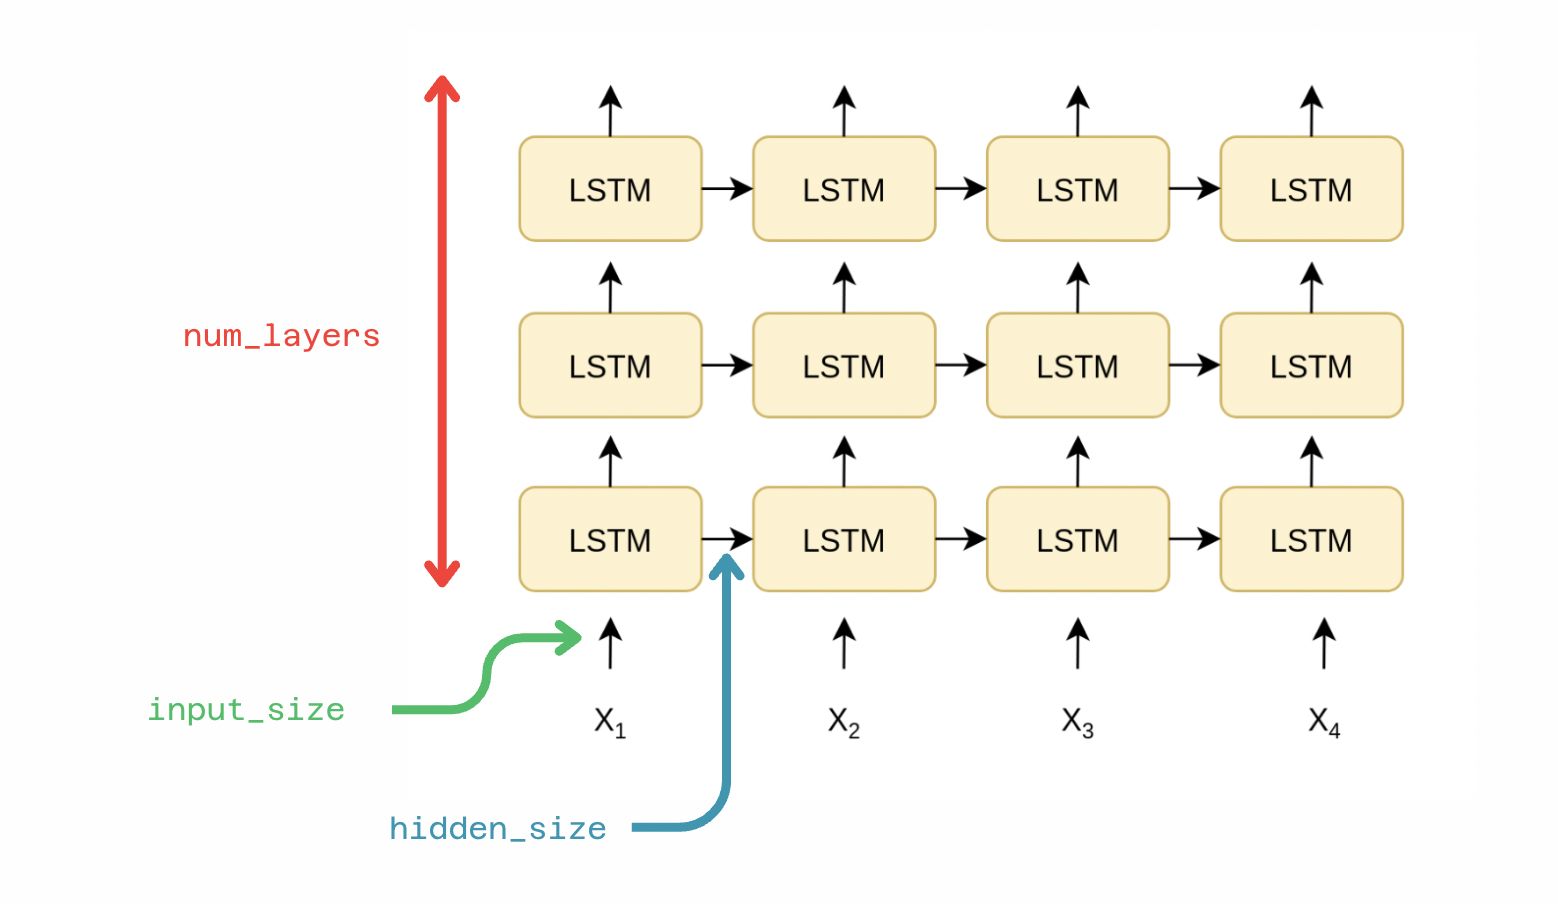

In [ ]:
lstm = nn.LSTM(
            2048, #input_size
            300, #hidden_size
            num_layers=2,
            bidirectional=True,
            dropout=0.1,
            batch_first=True
        )

LSTM zwraca tuple `(output, (h_n, c_n))`, gdzie:

1. `output`:
- Kształt: (batch_size, seq_length, hidden_size * num_directions)
- Zawiera stany ukryte z każdego kroku czasowego
- num_directions = 2 jeśli bidirectional=True, inaczej 1
- Dla każdego elementu sekwencji mamy wektor o długości hidden_size
- Użyteczne gdy potrzebujemy informacji z każdego kroku czasowego

2. `h_n` (hidden state):
- Kształt: (num_layers * num_directions, batch_size, hidden_size)
- Końcowy stan ukryty z ostatniego kroku czasowego
- Osobny stan dla każdej warstwy
- Przydatny gdy interesuje nas tylko końcowy wynik sekwencji

3. `c_n` (cell state):
- Kształt: (num_layers * num_directions, batch_size, hidden_size)
- Końcowy stan komórki z ostatniego kroku czasowego
- Wewnętrzna pamięć długoterminowa LSTM
- Zazwyczaj używany tylko do przekazywania stanu między batch'ami


In [ ]:
output  = lstm(sample_batch["text"][0])

In [ ]:
output[0].shape

torch.Size([40, 600])

In [ ]:
output[1][0].shape

torch.Size([4, 300])

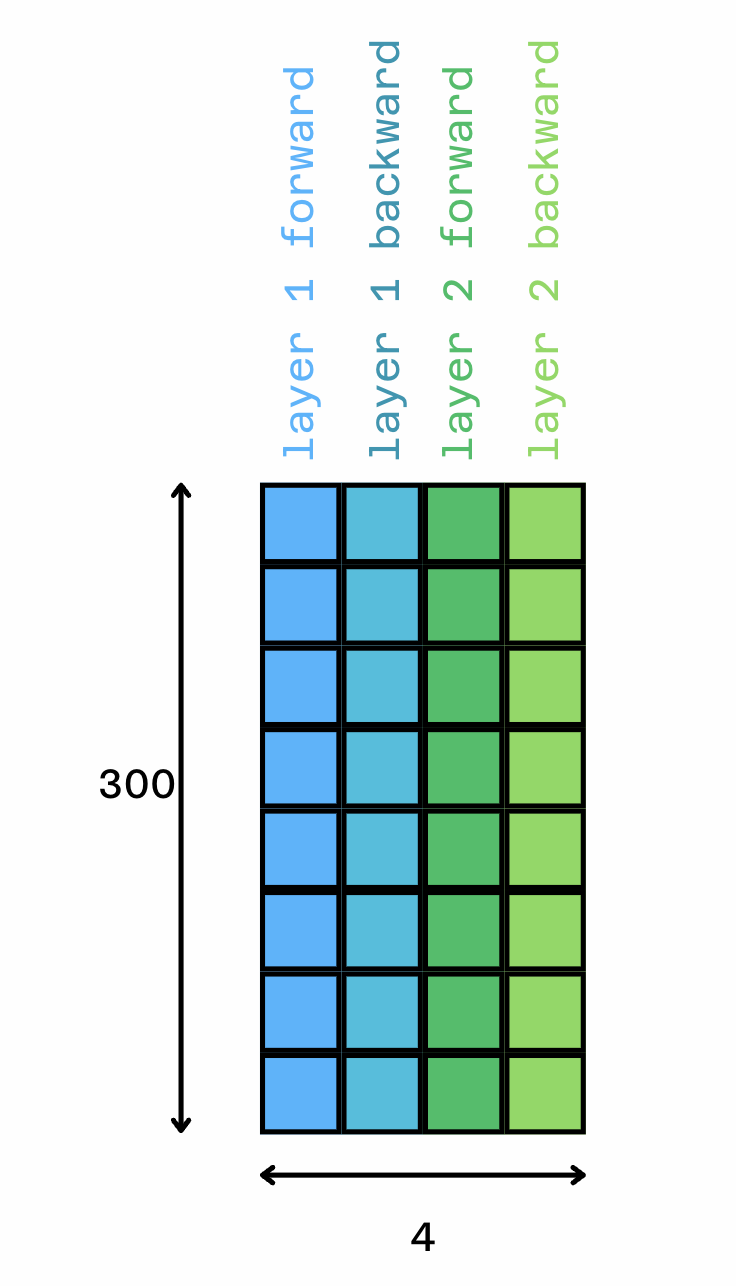

## Model

In [ ]:
import torchmetrics

class SpamClassifier(pl.LightningModule):
    def __init__(
        self,
        embedding_dim: int = 2048,
        hidden_dim: int = 300,
        n_layers: int = 2,
        dropout: float = 0.2
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout,
            batch_first=True
        ) # TODO: warstwa BiLSM

        self.fc = nn.Linear(hidden_dim * 2, 1) # TODO: warstwa klasyfikacyjne


        self.train_acc = torchmetrics.Accuracy(task = "binary")
        self.val_acc = torchmetrics.Accuracy(task = "binary")


    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x) # TODO: przejście przez warstwę LSTM

        # TODO: Konkatenacja ostatiego stanu ukrytego z warstwy forward i backward
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # TODO: Warstwa klasyfikacyjne
        output = self.fc(hidden)

        return output

    def training_step(self, batch, batch_idx):
        output = self(batch['text'])
        output = torch.sigmoid(output)
        loss = F.binary_cross_entropy(output.squeeze(), batch['label'])

        predictions = (output.squeeze() > 0.5).float()

        self.train_acc(predictions, batch['label'].int())
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        output = self(batch['text'])
        output = torch.sigmoid(output)
        loss = F.binary_cross_entropy(output.squeeze(), batch['label'])

        predictions = (output.squeeze() > 0.5).float()


        self.val_acc(predictions, batch['label'].int())

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

## Terening sieci

Radzę przejść na GPU, flair pod spodem też działa w pytorchu więc embeddingi też będą tworzone na GPU

In [ ]:
dm = SpamDataModule("data.csv", embedder, batch_size = 16, limit = 200) #200 wystarczy do testów, można zwiększyć ale wtedy trzeba embeddingi też robić w batchach bo dostaniemy OOM

model = SpamClassifier(
    embedding_dim=2048,
    hidden_dim=300,
    n_layers=2,
    dropout=0.2
)

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
)

# Train the model
trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Train size: 4180
Val size: 1394


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | lstm      | LSTM           | 7.8 M  | train
1 | fc        | Linear         | 601    | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
-----------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.222    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
